First, lets import all necessary modules, including Matplotlib for plotting

Also, define parameters for plotting, including colors

In [1]:
import os
import sys
import math
import copy

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
from libra_py import hungarian
from libra_py.workflows.nbra import step3

import matplotlib.pyplot as plt   # plots
%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, s

Here is where we define our model. For this model, we can denerate the Hvib matrices along the pre-computed trajectories (the NBRA assumption). NBRA = neglect of back-reaction approximation. 

In this example, we only imagine a system evolving in time such that the adiabatic energies and non-adiabatic couplings are constant for all times - really the simplest model problem. Well, in reality, this may be not that simple to realise, but we don't care here.

We generate a single data set (one "trajectory") - that's why len(Hvib) == 1 

The trajectory comprises nsteps = 1000 nuclear timesteps

Adiabatic energy levels are at -0.001 and 0.001 a.u. and the NAC is at 0.001 a.u. as well

In [2]:
def compute_reordering(St):
    """

    Performs the state's identity reordering in a given basis for all time steps.
    This is reflects in the corresponding changess of the TDM.

    Args:
        St ( list of CMATRIX(nstates, nstates) ): TDM for each timestep        
        
    Returns:
        None: but changes the input St object

    """

    nstates = St.num_of_cols
        
    # Current permutation
    perm_t = intList()     
    for a in range(nstates):
        perm_t.append(a)
        

    # Temporary matrices for the Hungarian method    
    en_mat = CMATRIX(nstates, nstates); 
    
    # compute the cost matrices for diagonal blocks
    cost_mat = step3.make_cost_mat(St, en_mat, 0.0)            

    # Solve the optimal assignment problem for diagonal blocks
    res_aa = hungarian.maximize(cost_mat)
    
    # Convert the list of lists into the permutation object
    for ra in res_aa:
        perm_t[ra[0]] = ra[1]  
    

    return perm_t    

In [3]:
def expH(H, dt):
    """
    Compute exp(-i*H*dt/hbar), hbar = 1
    """
    
    N = H.num_of_cols
    I = CMATRIX(N,N); I.identity()
    
    U, S, V = CMATRIX(N,N), CMATRIX(N,N), CMATRIX(N,N)
    
    #h = (1.0j) * H 
    
    #JacobiSVD_decomposition(h, U, S, V)
    #JacobiSVD_decomposition(H, U, S, V)
    BDCSVD_decomposition(H, U, S, V)
    
    #h = U * S * V.H()
    #for a in xrange(4):
    #    print a, h.get(a), H.get(a)
        
    
    #suu = U.H() * U0
    #svv = V.H() * V0
    #perm_uu = compute_reordering(suu)
    #perm_vv = compute_reordering(svv)    
    #print Cpp2Py(perm_uu), Cpp2Py(perm_vv)
    
    #U.permute_cols(perm_uu)
    #V.permute_cols(perm_vv)
    
    
    # H = U * S * V.H()
    expS = CMATRIX(N,N)
    expS *= 0.0
    
    #print S.get(0,0).real, S.get(0,0).imag, S.get(1,1).real, S.get(1,1).imag
    
    for i in range(N):
        argg = -S.get(i,i).real*dt        
        expS.set(i,i, math.cos(argg), math.sin(argg))
        
        #expS.set(i,i, math.exp(-dt * S.get(i,i).real ) ) 
        
    res = U * expS * V.H()
    
    return res


In [4]:
def expH2(H, dt):
    """
    exp(-i*dt*H/hbar)
    
    """
    N = H.num_of_cols
    tmp = CMATRIX(N,N)
    res = CMATRIX(N,N)
    
    res.identity()
    tmp.identity()
    
    for n in range(1,1000):
        tmp = ((-1.0j * dt)/float(n)) * H * tmp
        res = res + tmp
        
    return res

In [5]:
def correctedH(H, Coeff, T, case):
    
    sz = H.num_of_cols    
    kT = units.kB * T    
    
    
    rho = MATRIX(sz,1)    
    for i in range(sz):
        rho.set(i, 0, abs(Coeff.get(i,0)) )
    
    #============= Step 1 ===================
    Hcorr = CMATRIX(H)    
    for j in range(sz):
        for k in range(sz):
            if j!=k:                
                dE = H.get(k,k).real - H.get(j,j).real
                corr = math.sqrt(2.0 / (1.0 + math.exp(-dE/kT)) )                                
                Hcorr.scale(j,k, corr)
                
    #============= Step 2 ===================
    
    Hcorr2 = CMATRIX(sz,sz)
    for j in range(sz):
        for k in range(j+1,sz):
            if case==0:  # diabatic - original Bastida
                hkj = rho.get(k)*Hcorr.get(j,k) + rho.get(j)*Hcorr.get(k,j)
            elif case==1: # adiabatic - changed Bastida
                hkj = rho.get(k)*Hcorr.get(j,k) + rho.get(j)*Hcorr.get(k,j)
            
            Hcorr2.set(k,j, hkj)
            Hcorr2.set(j,k, hkj)
            
    return Hcorr2
    

In [6]:
def compute_dyn(H, Coeff, params, U0, V0):
    nstates = Coeff.num_of_rows
    nsteps = params["nsteps"]
    dt = params["dt"]
    Temp = params["Temperature"]
    case = params["Bastida_adi"]
    
    C = CMATRIX(Coeff)
    
    res = MATRIX(nsteps, 1+nstates*2)
    eH = CMATRIX(2,2)
    
    for i in range(nsteps):        
        D = C * C.H()
        norm = D.tr().real
        
        res.set(i, 0, dt*i)
        for j in range(nstates):
            res.set(i, 1+j, D.get(j,j).real)
            
            if norm>0.0:
                res.set(i, 1+nstates+j, D.get(j,j).real/norm)
            else:
                res.set(i, 1+nstates+j, 0.0)
                
                

        h = correctedH(H[i], C, Temp, case)
        #h = CMATRIX(H[i])
        
        # SVD
        #C = expH(H[i], dt) * C
        
        # Eigensolver - gives wrong dynamics!
        #exp_matrix(eH, H[i], dt*(0.0-1.0j))
        #C = eH * C
        
        # Direct
        #C = expH2(H[i], dt) * C
        #C = exp_2(h, -1.0j*dt) * C
        
        #D = C * C.H()
        #norm = D.tr().real
        #C *= (1.0/math.sqrt(norm))
        
        # Current way:
        propagate_electronic(dt, C, h)
    
    return res    

Lets test the propagators for a single dt

In [7]:
dt = 10.0

hvib = CMATRIX(2,2)
hvib.set(0,0, 0.0+0.0j);     hvib.set(0,1, 0.0+0.001j);
hvib.set(1,0, 0.0-0.001j);   hvib.set(1,1, 0.001+0.0j);

#C = expH(hvib, dt) * Coeff

#D = C * C.H()
#print D.get(0,0).real, D.get(1,1).real

In [8]:
E1, E2 = expH(hvib, dt), expH2(hvib, dt)   # SVD,  direct

E3 = CMATRIX(2,2)
exp_matrix(E3, hvib, dt*(0.0-1.0j))  # eigensolver

print( "           SVD                                      Direct                            Eigensolver" )
for i in range(4):
    print( i, E1.get(i), E2.get(i), E3.get(i))

           SVD                                      Direct                            Eigensolver
0 (-0.4472359554343836+1.666641666819499e-07j) (0.9999500008333263+1.6666416668253966e-07j) (0.9999500008333262+1.6666416668455197e-07j)
1 (0.0099996666708333+0.8943601102649523j) (0.009999666670833308-4.999875001111106e-05j) (0.009999666670833301-4.999875001110432e-05j)
2 (-0.0099996666708333-0.8943601102649523j) (-0.009999666670833308+4.999875001111106e-05j) (-0.009999666670833303+4.999875001110432e-05j)
3 (0.4471241548305687-0.00999950000666662j) (0.9999000020833152-0.009999500006666625j) (0.9999000020833151-0.009999500006666622j)


In [9]:
nsteps = 1000

# Populate Hvib - this is our model
Hvib = []
hvib = []

Temp = 5000.0
bf = math.exp(-0.01/(units.kB*Temp))
ibf = 1.0/bf
print( bf)


for i in range(nsteps):
    hvib.append(CMATRIX(2,2))
    hvib[i].set(0,0, 0.0);     hvib[i].set(0,1, -0.001j);
    hvib[i].set(1,0, 0.001j);   hvib[i].set(1,1, 0.001);
Hvib.append(hvib)

0.5317672772629725


In [10]:
Coeff = CMATRIX(2,1)
Coeff.set(0,0, 0.0+0.0j)
Coeff.set(1,0, 1.0+0.0j)

D = Coeff * Coeff.H()
print( "State populations:", D.get(0,0).real, D.get(1,1).real)

U0 = CMATRIX(2,2)
S0 = CMATRIX(2,2)
V0 = CMATRIX(2,2)
JacobiSVD_decomposition(Hvib[0][0], U0, S0, V0)

params = {"nsteps":nsteps, "dt":10.0, "Temperature": 1000.0, "Bastida_adi":1 }
res = compute_dyn(Hvib[0], Coeff, params, U0, V0)

print( params)
bf = math.exp(-0.001/(units.kB*params["Temperature"]))
print( bf)

State populations: 0.0 1.0
{'nsteps': 1000, 'dt': 10.0, 'Temperature': 1000.0, 'Bastida_adi': 1}
0.7292237497935543


Convert the results into a plottable format

In [12]:
t = []
P0, P1 = [], []
nP0, nP1 = [], []
for i in range(nsteps):
    t.append(res.get(i, 0)*units.au2fs )  # time
    P0.append(res.get(i, 1))  # raw pop of state 0
    P1.append(res.get(i, 2))  # raw pop of state 1
    nP0.append(res.get(i, 3))  # normalized pop of state 0
    nP1.append(res.get(i, 4))  # normalized pop of state 1

Finally, we can plot the results. 

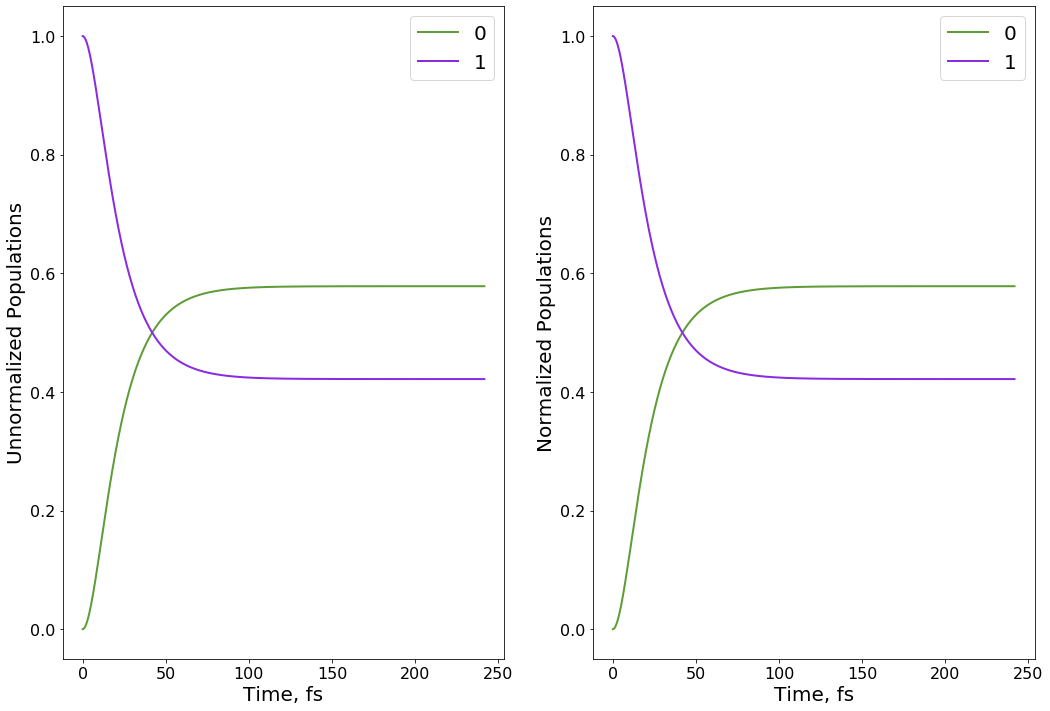

In [13]:
plt.figure(1, figsize=(18, 12)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.xlabel('Time, fs')
plt.ylabel('Unnormalized Populations')
plt.plot(t, P0, label='0', linewidth=2, color = colors["21"]) 
plt.plot(t, P1, label='1', linewidth=2, color = colors["31"]) 
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Time, fs')
plt.ylabel('Normalized Populations')
plt.plot(t, nP0, label='0', linewidth=2, color = colors["21"]) 
plt.plot(t, nP1, label='1', linewidth=2, color = colors["31"]) 
plt.legend()

plt.show()
plt.close()

In [14]:
print( nP1[nsteps-1]/nP0[nsteps-1])

0.729225553582255
